In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
import utils
import simple_data_vis as vis
import dab_nn_defs as engine
#import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# load data from just-private/data
parentdir="."
filename1 = 'mol_res_scan_results_12B.csv'
data1 = utils.load_data(parentdir,filename1)

filename2 = 'mol_res_scan_results8B.csv'
data2 = utils.load_data(parentdir,filename2)

filename3 = 'mol_res_scan_results9B.csv'
data3 = utils.load_data(parentdir,filename3)

filename4 = 'mol_res_scan_results10B.csv'
data4 = utils.load_data(parentdir,filename4)

filename5 = 'mol_res_scan_results11B.csv'
data5 = utils.load_data(parentdir,filename5)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
# should be the same for both datasets
x = [*data1.columns[:2],*data1.columns[4:]]
y = data1.columns[2:4]

In [4]:
def data_pipeline(array, x, y):
    splits = []
    for a in array:
        a = utils.preprocessing([a,], bounds = {'yield':[0,1],'purity':[0,1]})[0]
        train_x, test_x, train_y, test_y = utils.chroma_train_test_split(a, x, y)
        train_x, test_x, scaler_x = utils.preprocessing(
                                    [train_x, test_x], 
                                    standarize = True, 
                                    skip = ['cut 1','cut 2']
                                    )
        splits.append([train_x, train_y])
        splits.append([test_x, test_y])

    return splits

In [5]:
train1, test1, train2, test2, train3, test3, train4, test4, train5, test5 = data_pipeline([data1,data2,data3,data4,data5],x,y)
# could add this bit to data_pipeline
trains = [train1, train2, train3, train4, train5]
tests = [test1, test2, test3, test4, test5]

In [6]:
# define models to test out. a loop makes sense too 
def generate_models(filenames):
    models = []
    for filename in filenames:
        dlr = engine.create_deterministic_linear_regressor(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            name = 'DLR_'+filename[:-4]
        )

        plr = engine.create_probabilistic_linear_regressor(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            name = 'PLR_'+filename[:-4],
        )

        dnn = engine.create_deterministic_nn(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            hidden_units = [16,8,4],
            name = 'DNN_'+filename[:-4]
        )

        pnn = engine.create_probabilistic_nn(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            hidden_units = [16,8,4,],
            name = 'PNN_'+filename[:-4],
        )

        models.append([dlr,plr,dnn,pnn])
    return models

all_models = generate_models([filename1,filename2,filename3,filename4,filename5])

In [7]:
# train all the models under the same conditions
learning_rate = 0.01
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/trains[0][1].mean().div(trains[0][1].mean().max())).round(2).to_dict() 
histories = {}

for models, train, test, filename in zip(all_models, trains, tests, [filename1,filename2,filename3,filename4,filename5]):
    for m,l in zip(models,losses):
        histories[utils.get_model_name(m,filename)] = engine.run_experiment(
            model = m, 
            loss = {y[0]:l,y[1]:l},
            loss_weights = loss_weights,
            optimizer = tf.keras.optimizers.Adam,
            learning_rate = learning_rate,
            num_epochs = epochs,
            train_dataset = train, 
            test_dataset = test,
            verbose = 0,
            log = 0
            )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename1+'\n'+filename2+'\n'+filename3+'\n'+filename4+'\n'+filename5}

Start training the model DLR_mol_res_scan_results_12B ...
Evaluating model performance...
Train MSE: 2.486
Test MSE: 2.448
Start training the model PLR_mol_res_scan_results_12B ...
Evaluating model performance...
Train MSE: 6.085
Test MSE: 6.156
Start training the model DNN_mol_res_scan_results_12B ...
Evaluating model performance...
Train MSE: 0.075
Test MSE: 0.076
Start training the model PNN_mol_res_scan_results_12B ...
Evaluating model performance...
Train MSE: 0.354
Test MSE: 0.429
Start training the model DLR_mol_res_scan_results8B ...
Evaluating model performance...
Train MSE: 2.283
Test MSE: 1.795
Start training the model PLR_mol_res_scan_results8B ...
Evaluating model performance...
Train MSE: 2.395
Test MSE: 1.901
Start training the model DNN_mol_res_scan_results8B ...
Evaluating model performance...
Train MSE: 0.072
Test MSE: 0.083
Start training the model PNN_mol_res_scan_results8B ...
Evaluating model performance...
Train MSE: 0.453
Test MSE: 0.34
Start training the model 

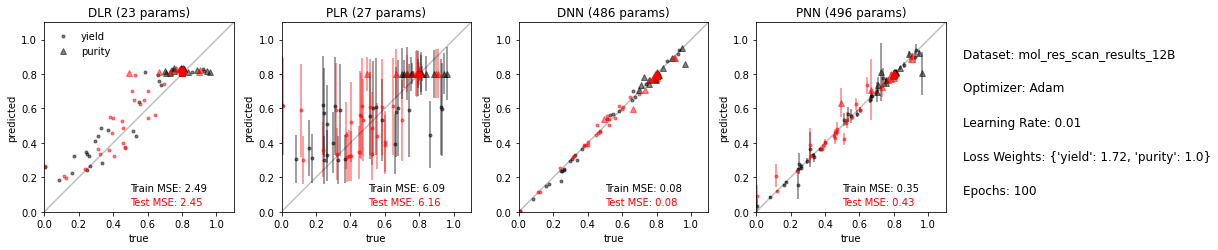

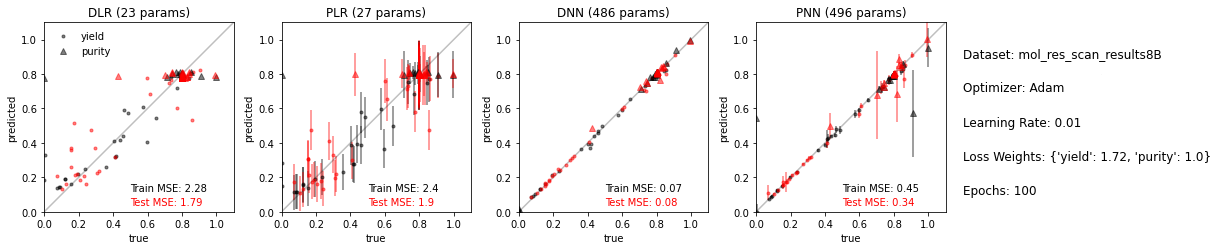

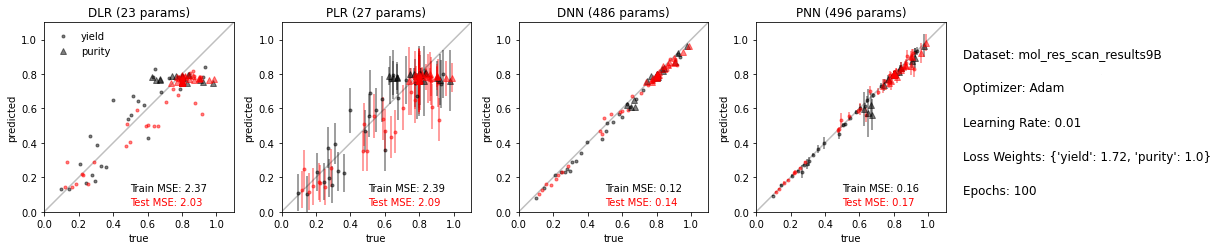

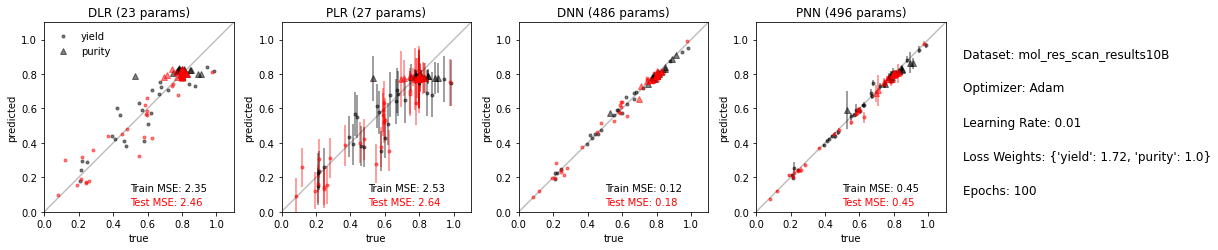

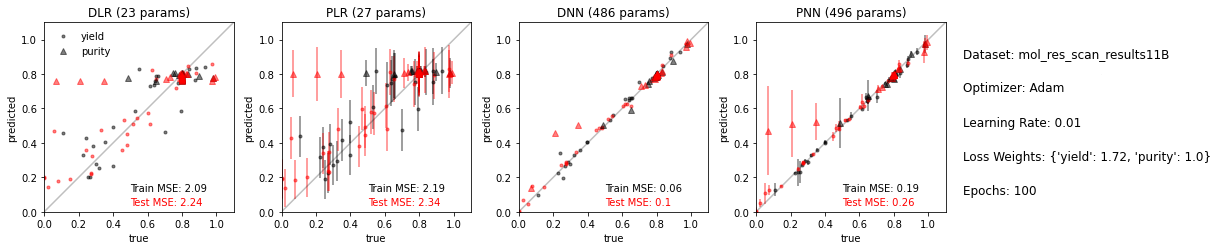

In [8]:
# check model predictions
settings['dataset'] = filename1
vis.scatter_hats(all_models[0], trains[0], tests[0], settings, N = 25)
settings['dataset'] = filename2
vis.scatter_hats(all_models[1], trains[1], tests[1], settings, N = 25)
settings['dataset'] = filename3
vis.scatter_hats(all_models[2], trains[2], tests[2], settings, N = 25)
settings['dataset'] = filename4
vis.scatter_hats(all_models[3], trains[3], tests[3], settings, N = 25)
settings['dataset'] = filename5
vis.scatter_hats(all_models[4], trains[4], tests[4], settings, N = 25)

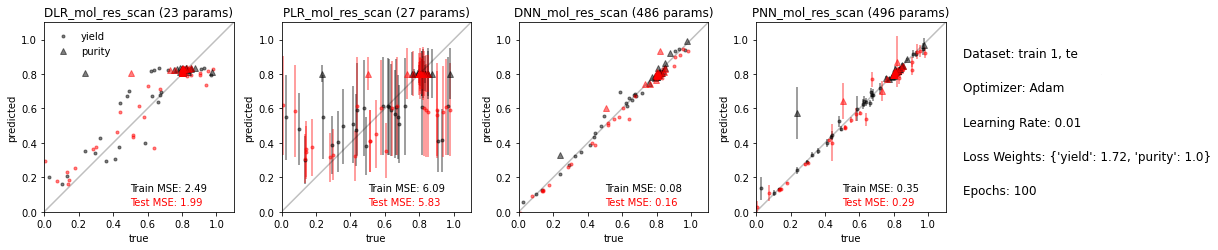

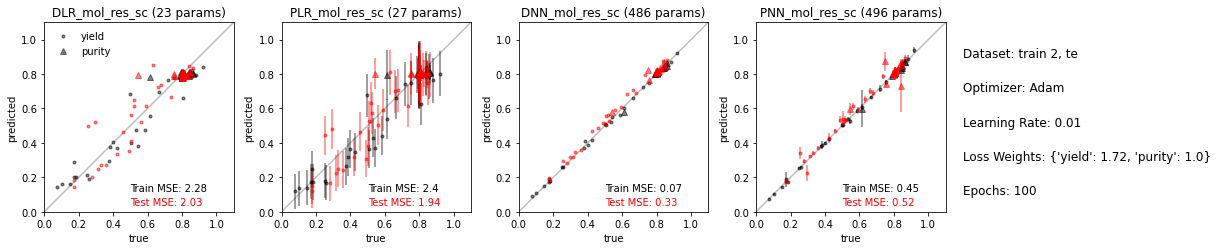

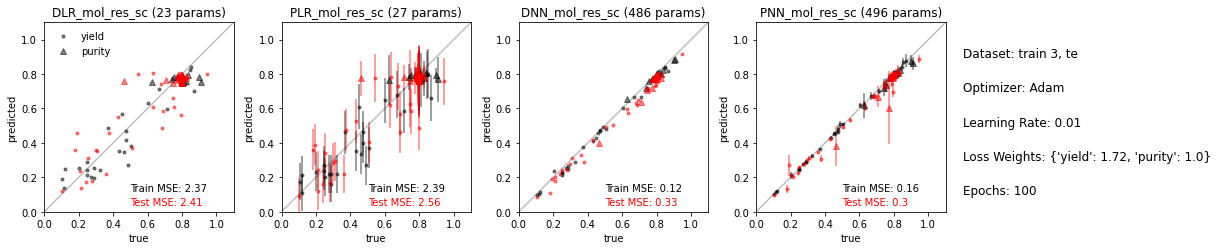

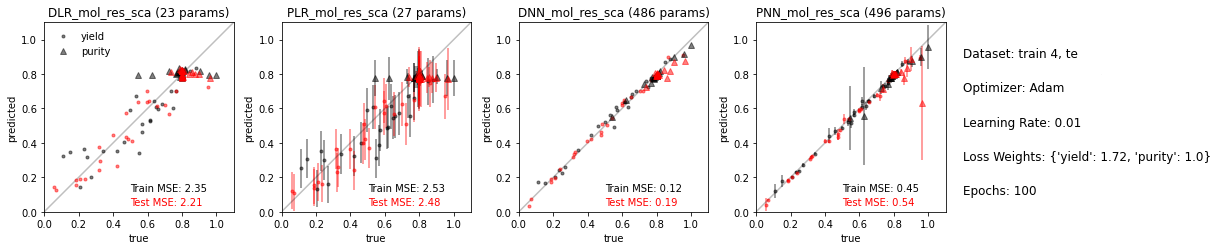

In [9]:
settings['dataset'] = 'train 1, test 2'
vis.scatter_hats(all_models[0], trains[0], tests[1], settings, N = 25)
settings['dataset'] = 'train 2, test 3'
vis.scatter_hats(all_models[1], trains[1], tests[2], settings, N = 25)
settings['dataset'] = 'train 3, test 4'
vis.scatter_hats(all_models[2], trains[2], tests[3], settings, N = 25)
settings['dataset'] = 'train 4, test 5'
vis.scatter_hats(all_models[3], trains[3], tests[4], settings, N = 25)

In [23]:
data2.index = data2.index + len(data1)
all_data = data1.append(data2)
data3.index = data3.index + len(data2)
all_data=all_data.append(data3)
data4.index = data4.index + len(data3)
all_data=all_data.append(data4)
data5.index = data5.index + len(data4)
all_data=all_data.append(data5)

In [26]:
all_train, all_test = data_pipeline([all_data,],x,y)

In [27]:
ra_models = generate_models(['S+Q',])[0]

In [28]:
# this is why we make functions...

learning_rate = 0.005
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/all_train[1].mean().div(all_train[1].mean().max())).round(2).to_dict() 
histories = {}

for m,l in zip(ra_models,losses):
    histories[utils.get_model_name(m,'S+Q')] = engine.run_experiment(
        model = m, 
        loss = {y[0]:l,y[1]:l},
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = all_train, 
        test_dataset = all_test,
        verbose = 0,
        log = 0
        )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : 'impurity'}

Start training the model DLR_ ...
Evaluating model performance...
Train MSE: 2.22
Test MSE: 2.181
Start training the model PLR_ ...
Evaluating model performance...
Train MSE: 2.286
Test MSE: 2.283
Start training the model DNN_ ...
Evaluating model performance...
Train MSE: 0.058
Test MSE: 0.06
Start training the model PNN_ ...
Evaluating model performance...
Train MSE: 0.534
Test MSE: 0.523


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

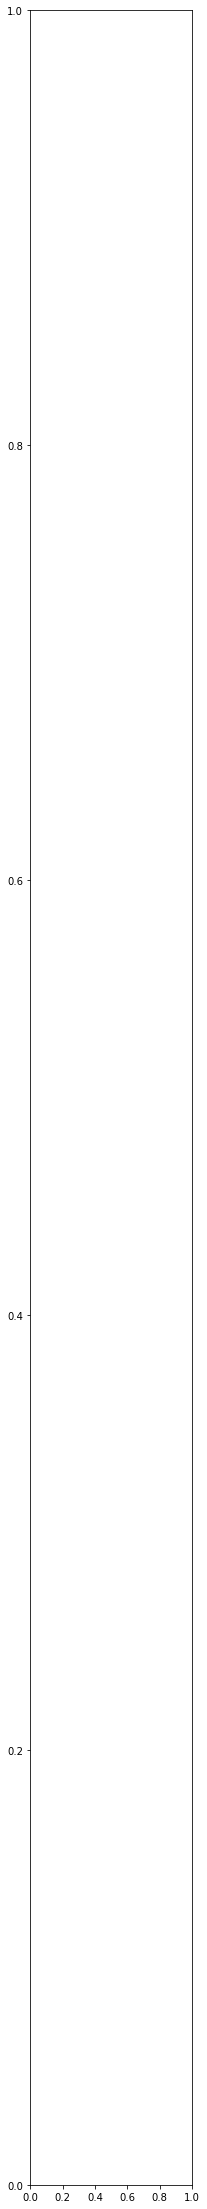

In [29]:
vis.scatter_hats(ra_models, all_train, all_test, settings, N = 25)